In [7]:
import numpy as np
import scipy.io as sio

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from scipy.stats import zscore

In [8]:
class Task(object):
    """ 
        Iterable task object
    """
    def __init__(self, max_iter=None, batch_size=1):
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.num_iter = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if (self.max_iter is None) or (self.num_iter < self.max_iter):
            self.num_iter += 1
            return (self.num_iter - 1) , self.sample()
        else:
            raise StopIteration()

    def sample(self):
        raise NotImplementedError()
        

In [10]:
class Harvey2012(Task):
    '''Parameters'''
    def __init__(self, max_iter=None, batch_size=50, n_in=50, n_out=1, stim_dur=25, delay_dur=100, resp_dur=25, sigtc=15.0, stim_rate=1.0, spon_rate=0.1):
        super(Harvey2012, self).__init__(max_iter=max_iter, batch_size=batch_size)
        self.n_in      = n_in                             
        self.n_out     = n_out
        self.tau       = 1.0 / sigtc**2
        self.spon_rate = spon_rate
        self.phi       = np.linspace(-40.0, 40.0, self.n_in) 
        self.stim_dur  = stim_dur
        self.delay_dur = delay_dur
        self.resp_dur  = resp_dur
        self.total_dur = stim_dur + delay_dur + resp_dur
        self.stim_rate = stim_rate
        
    def sample(self):                        
        # Left-right choice         
        C              = np.random.choice([0.0, 1.0], size=(self.batch_size,))
        S              = -15.0 * (C==0.0) + 15.0 * (C==1.0)
                
        # Noisy responses
        # Make rates for each period of the trial
        Ls             = (self.stim_rate / self.stim_dur) * np.exp(-0.5 * self.tau * ( np.tile(np.swapaxes(np.tile(S, (1,1,1)), 0,2),(1, self.stim_dur, self.n_in)) - np.tile(self.phi,(self.batch_size,self.stim_dur,1) ) )**2 )
        Ld             = (self.spon_rate / self.delay_dur) * np.ones((self.batch_size, self.delay_dur, self.n_in)) 
        Lr             = (self.spon_rate / self.resp_dur) * np.ones((self.batch_size, self.resp_dur, self.n_in))
        # Poisson random draws from rates
        Rs             = np.random.poisson(Ls)
        Rd             = np.random.poisson(Ld)
        Rr             = np.random.poisson(Lr)

        example_input  = np.concatenate((Rs,Rd,Rr), axis=1)
        example_output = np.repeat(C[:,np.newaxis],self.total_dur,axis=1)
        example_output = np.repeat(example_output[:,:,np.newaxis],1,axis=2)

        cum_Rs         = np.sum(Rs,axis=1)
        prec           = np.sum(cum_Rs,axis=1) * self.tau
        mu             = self.tau * np.dot(cum_Rs,self.phi) / prec
        d              = 0.5 * prec * ( (-15.0 - mu)**2 - (15.0 - mu)**2 ) 
        P1             = 1.0 / (1.0 + np.exp(-d)) # difficulty metric?

        return torch.from_numpy(example_input).double() , torch.from_numpy(example_output).double(),C, P1
    
    

In [362]:
class RecurrentModel(nn.Module):
    """
        Generalized RNN model from Rylan Schaeffer
    """
    def __init__(self,model_kwargs):
        super(RecurrentModel, self).__init__()
        self.model_kwargs = model_kwargs
        self.input_size = model_kwargs['input_size']
        self.output_size = model_kwargs['output_size']
        self.batch_size = model_kwargs['batch_size']

        # create and save core i.e. the recurrent operation
        self.core = self._create_core(model_kwargs=model_kwargs)

        self.readout = nn.Linear( # linear output layer
            in_features=model_kwargs['core_kwargs']['hidden_size'],
            out_features=self.output_size,
            bias=True)
        
        param_init_(self) 
        self.reset_core_hidden()

        # converts all weights into doubles i.e. float64
        # this prevents PyTorch from breaking when multiplying float32 * float64
        self.double()

    def _create_core(self, model_kwargs):
        core = nn.RNN(
            input_size=self.input_size,
            batch_first=True,
            **model_kwargs['core_kwargs'])

        # we also don't currently do anything fancy here
#         param_init_str = model_kwargs['param_init']
#         param_init(core,param_init_str)

        return core

    def reset_core_hidden(self):
        self.core_hidden = torch.zeros(self.output_size,self.batch_size,self.model_kwargs['core_kwargs']['hidden_size'],dtype = torch.double)

    def forward(self,x):
        """
        Performs a forward pass through model.

        :param model_input: Tensor with shape (batch size, num step, stimulus dimension)
            
        :return forward_output: dictionary containing 4 keys:
            core_output: Tensor of shape (batch size, num steps, core dimension)
            readout_output: Tensor of shape (batch size, num steps, core dimension)
            readout: Tensor of shape (batch size, num steps, output dimension)
        """ 
        # reset hidden 
        self.reset_core_hidden()
        
        # run trials and get core output
        core_output, new_core_hidden = self.core(x,self.core_hidden)
                
        readout_output = torch.sigmoid(self.readout(core_output))
        
        forward_output = dict(
            core_output = core_output,
            readout_output = readout_output)

        return forward_output

# parameter initialization functions 
def diag_init(tensor: torch.Tensor, offdiag_val : np.float64, diag_val: np.float64) -> torch.Tensor:
    """ 
        Initialize parameters, separating onn and off diag
        In place operation
    """
    shape = tensor.shape
    if len(shape) != 2 or shape[0] != shape[1]:
        raise ValueError('LeInit initializer can only be used for 2D square matrices.')

    off_diag_part = offdiag_val * np.random.randn(shape[0], shape[1])
    tensor = torch.tensor(np.eye(shape[0]) * diag_val + off_diag_part - np.diag(np.diag(off_diag_part)))
    return tensor

def param_init_(recurrent_model):    
    param_init_kwargs = recurrent_model.model_kwargs['param_init_kwargs'] 
#     with torch.no_grad():
    if recurrent_model.model_kwargs['param_init_fn'] == "diag_init_": 
        # Init input-hidden according to Xavier Normal, g = 0.95
        nn.init.xavier_normal_(recurrent_model.core.weight_ih_l0,gain = 0.95).double()
        # Init hidden-hidden according to diag-off-diag decomposition method
        recurrent_model.core.weight_hh_l0 = torch.nn.Parameter(diag_init(recurrent_model.core.weight_hh_l0,param_init_kwargs['offdiag_val'],param_init_kwargs['diag_val'])).double()
        # Init hidden-output according to Xavier Normal, g = 0.95
        nn.init.xavier_normal_(recurrent_model.readout.weight,gain = 0.95).double()

        

In [466]:
# define model parameters
n_in = 50
n_out = 1
n_hid =  500
nonlinearity = 'relu'
model_kwargs = {
                'input_size': n_in, # input: patch_on,patch_off,rew,time_on_patch,time_since_rew
                'output_size': n_out,
                'batch_size': 50,
                'core_kwargs': {
                    'num_layers': 1, 
                    'hidden_size': n_hid,
                    'nonlinearity': nonlinearity},
                'param_init_fn': 'diag_init_',
                'param_init_kwargs': 
                    {
                        'offdiag_val': 0 / np.sqrt(n_hid),
                        'diag_val': .98 
                    },
                'connectivity_kwargs': { 
                    'input_mask': 'none',
                    'recurrent_mask': 'none',
                    'readout_mask': 'none',
                                        },
                }


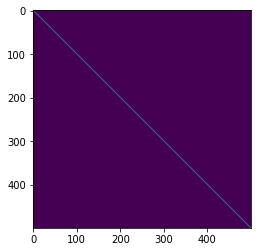

In [467]:
# show weights 
model = RecurrentModel(model_kwargs)
plt.imshow(model.core.weight_hh_l0.detach())
plt.show()

In [468]:
# dry run on an example task
ex_task = Harvey2012()
example_input, example_output, C, P1 = ex_task.sample()
output_dict = model.forward(example_input)


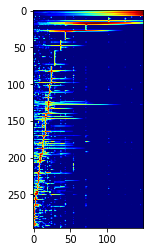

In [481]:
def peaksort_vis_trial(core_activity : torch.Tensor): 
    """
        Peaksort visualization of network activity during task
    """ 
    core_activity = core_activity.detach().numpy().T
    core_activity = core_activity[np.any(core_activity[:,25:-25]!= 0,1),:]
    ix = np.argmax(core_activity,1)
    peaksort = np.argsort(ix)
    plt.imshow(np.flipud(core_activity[peaksort,:] / np.max(core_activity,1)[peaksort,np.newaxis]),cmap = 'jet')

peaksort_vis_trial(output_dict['core_output'][0])

In [155]:
# Show tiled range of dynamics based on diagonal initializations (Sup figure 1)
example_input, example_output, C, P1 = ex_task.sample()
sigma_range = np.linspace(0.2/np.sqrt(n_hid),0.4/np.sqrt(n_hid),10)
lambda_range = np.linspace(.7,1.1,8)
fig1, f1_axes = plt.subplots(nrows=len(sigma_range), ncols=len(lambda_range),figsize = (10,18),sharex = True,sharey = True)
for i,this_sigma in enumerate(sigma_range): 
    for j,this_lambda in enumerate(lambda_range):
        these_model_kwargs = model_kwargs 
        these_model_kwargs['param_init_kwargs']['offdiag_val'] = this_sigma
        these_model_kwargs['param_init_kwargs']['diag_val'] = this_lambda
        this_model = RecurrentModel(these_model_kwargs)
        output_dict = this_model.forward(example_input)
#         a = peaksort_vis_trial(output_dict['core_output'][0])
        core_activity = output_dict['core_output'][0].detach().numpy().T
        readout_activity = output_dict['readout_output'][0].detach().numpy()
        core_activity = core_activity[np.any(core_activity != 0,1),:]
        ix = np.argmax(core_activity,1)
        peaksort = np.argsort(ix)
#         f1_axes[i,j].imshow(np.flipud(core_activity[peaksort,:] / np.max(core_activity,1)[peaksort,np.newaxis]),cmap = 'jet')
        f1_axes[i,j].plot(readout_activity)
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x12ca41dc0> (for post_execute):


KeyboardInterrupt: 

In [433]:
def gradClamp(parameters, clip=100):
    """
        Element-wise gradient clipping
    """
    for p in parameters:
        p.grad.data.clamp_(-clip,clip)

def binary_crossentropy(x,target,readout_clip = 1e-6): 
    """
        Compute the binary cross-entropy between predictions and targets.
    """
    x = torch.clamp(x,readout_clip,1-readout_clip)
    return - target * torch.log(x) - (1 - target) * torch.log(1 - x)

In [477]:
# Ready the training
n_batches = 25001
resp_dur = 25
task = Harvey2012(max_iter = n_batches,resp_dur = resp_dur)
model = RecurrentModel(model_kwargs)

# Training parameters
activity_l2_penalty = 1e-4 
activity_penalty_steps = 5 # number of activity steps before trial end to penalize
param_l2_penalty = 1e-4 # (aka weight decay)
lr = 0.0005
grad_clip = 100
ce_loss = nn.CrossEntropyLoss(reduction = "mean")
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr) # , weight_decay = param_l2_penalty)
total_losses = np.zeros(n_batches)
ce_losses = np.zeros(n_batches)


In [478]:
# loss function: T.mean(lasagne.objectives.binary_crossentropy(pred_var[:,-resp_dur:,-1], target_var[:,-resp_dur:,-1])) 
model.double()

# TRAINING
s_vec, opt_vec, net_vec, infloss_vec = [], [], [], []
for i, (example_input, example_output, s, opt) in task: # loop over batches in training set 
    optimizer.zero_grad() # zero the gradients
    output_dict = model.forward(example_input) # perform forward pass
    
    s_vec.append(s)
    opt_vec.append(opt)
    net_vec.append(output_dict['readout_output'][:,-5,:].detach().numpy())
    
    # calculate loss
    l2_penalized_activity = output_dict['core_output'][:,-activity_penalty_steps:,:]
    activity_l2_loss = activity_l2_penalty * mse_loss(l2_penalized_activity,torch.zeros(l2_penalized_activity.shape,dtype = torch.double))

    readout_activity = output_dict['readout_output'][:,-resp_dur:,-1] 
    target = np.squeeze(example_output[:,:,-1].long().unique(dim = 1))
    this_ce_loss = binary_crossentropy(readout_activity,np.squeeze(example_output[:,-resp_dur:,-1].long())).mean()

    loss = (activity_l2_loss + this_ce_loss).double() # activity_l2_loss 
#     loss = this_ce_loss
    loss.backward() # backpropagate gradients
    gradClamp(model.parameters(), clip = grad_clip) # clip gradients 
    optimizer.step() # perform optimization step
    
    total_losses[i] = loss.item() 
    ce_losses[i] = this_ce_loss.item()

    if i % 5 == 0:
        opt_vec = np.asarray(opt_vec)
        net_vec = np.asarray(net_vec)
        s_vec   = np.asarray(s_vec)
        print('Batch #%d; Total Loss: %.6f; CE Loss: %.6f' % (i, loss, this_ce_loss))
        l_acc = np.mean(net_vec[s_vec == 0] < 0.5)
        r_acc = np.mean(net_vec[s_vec == 1] > 0.5)
        print('\t Left trial accuracy: %.3f; Right trial accuracy: %.3f' % (l_acc,r_acc))
        s_vec, opt_vec, net_vec, infloss_vec = [], [], [], []


Batch #0; Total Loss: 1.075449; CE Loss: 1.075277
	 Left trial accuracy: 1.000; Right trial accuracy: 0.000
Batch #5; Total Loss: 1.321200; CE Loss: 1.321187
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #10; Total Loss: 0.939116; CE Loss: 0.939111
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #15; Total Loss: 0.813576; CE Loss: 0.813572
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #20; Total Loss: 0.762515; CE Loss: 0.762512
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #25; Total Loss: 0.724033; CE Loss: 0.724030
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #30; Total Loss: 0.730024; CE Loss: 0.730021
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #35; Total Loss: 0.679093; CE Loss: 0.679090
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #40; Total Loss: 0.703887; CE Loss: 0.703885
	 Left trial accuracy: 0.000; Right trial accuracy: 1.000
Batch #45; Total Loss

KeyboardInterrupt: 

array([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.])

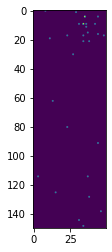

In [332]:
plt.imshow(example_input[5].detach().numpy())
C

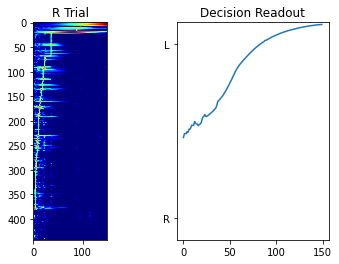

In [479]:
tts = ["L","R"]
vis_trial = 1
plt.figure()
plt.subplot(1,2,1)
peaksort_vis_trial(output_dict['core_output'][vis_trial])
plt.title("%s Trial"%tts[int(C[vis_trial])])
plt.subplot(1,2,2)
plt.plot(output_dict['readout_output'][vis_trial].detach().numpy())
plt.title("Decision Readout")
plt.yticks([.1,.9],["R","L"])
# plt.yticklabels(["L","R"])
plt.ylim([0,1]);
